In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator


In [95]:
gdp_pcap = pd.read_csv("data/gdp_pcap.csv", index_col="country")

# drop all years in the future
gdp_cols_numeric = pd.to_numeric(gdp_pcap.columns, errors="coerce")
gdp_future_cols = gdp_pcap.columns[(gdp_cols_numeric.notna()) & (gdp_cols_numeric > 2022)]
gdp_pcap.drop(columns=gdp_future_cols, inplace=True)

# convert thousand values marked with 'k' into numeric
gdp_pcap[:] = gdp_pcap.apply(lambda s: pd.to_numeric(s.astype(str).str.replace('k', 'e3', regex=False), errors='coerce'))

gdp_pcap.head()


,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,481,481,481,481,481,481,481,481,481,481,...,2170.0,2150.0,2110.0,2100.0,2100.0,2060.0,2080.0,1970.0,1520.0,1390.0
Angola,373,374,376,378,379,381,383,385,386,388,...,8100.0,8180.0,7970.0,7490.0,7220.0,6880.0,6600.0,6030.0,5910.0,5910.0
Albania,469,471,472,473,475,476,477,479,480,482,...,11400.0,11600.0,11900.0,12300.0,12800.0,13300.0,13700.0,13300.0,14600.0,15500.0
Andorra,1370,1370,1370,1380,1380,1380,1390,1390,1390,1390,...,55700.0,56600.0,56500.0,57500.0,56400.0,56200.0,56300.0,49700.0,52800.0,56400.0
UAE,1140,1150,1150,1150,1160,1160,1170,1170,1180,1180,...,62100.0,64100.0,67800.0,70900.0,70900.0,71200.0,71500.0,67400.0,69700.0,74600.0


In [96]:
co2 = pd.read_csv("data/co2_pcap_cons.csv", index_col="country")

# drop all years in the future
co2_cols_numeric = pd.to_numeric(co2.columns, errors="coerce")
co2_future_cols = co2.columns[(co2_cols_numeric.notna()) & (co2_cols_numeric > 2022)]
co2.drop(columns=co2_future_cols, inplace=True)

co2.head()


,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.28,0.253,0.262,0.245,0.247,0.254,0.261,0.261,0.279,0.284
Angola,0.009,0.009,0.009,0.009,0.009,0.009,0.010,0.010,0.010,0.010,...,1.28,1.640,1.220,1.180,1.150,1.120,1.150,1.120,1.200,1.230
Albania,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,2.27,2.250,2.040,2.010,2.130,2.080,2.050,2.000,2.120,2.100
Andorra,0.333,0.335,0.337,0.340,0.342,0.345,0.347,0.350,0.352,0.355,...,5.9,5.830,5.970,6.070,6.270,6.120,6.060,5.630,5.970,5.910
UAE,0.063,0.063,0.064,0.064,0.064,0.064,0.065,0.065,0.065,0.065,...,27,26.800,27.000,26.700,23.900,23.500,21.200,19.700,20.700,21.100


In [97]:
regions = pd.read_csv("data/regions.csv")

# only keep relevant cols
regions = regions[["name", "four_regions"]].copy()

# set index
regions.set_index("name", inplace=True)

regions.head()


,four_regions
name,
Australia,asia
Brunei,asia
Cambodia,asia
China,asia
Fiji,asia


In [98]:
# add region column
gdp_pcap = gdp_pcap.join(regions.rename(columns={"four_regions": "region"}))
co2 = co2.join(regions.rename(columns={"four_regions": "region"}))


In [99]:
# select numeric year columns from 1950 onwards
year_cols = gdp_pcap.columns[gdp_pcap.columns.str.fullmatch(r"\d{4}")]
years = year_cols[year_cols.astype(int) >= 1950]

gdp_panel = gdp_pcap[years].copy()
co2_panel = co2[years].copy()

gdp_panel['region'] = gdp_pcap['region']
co2_panel['region'] = co2['region']


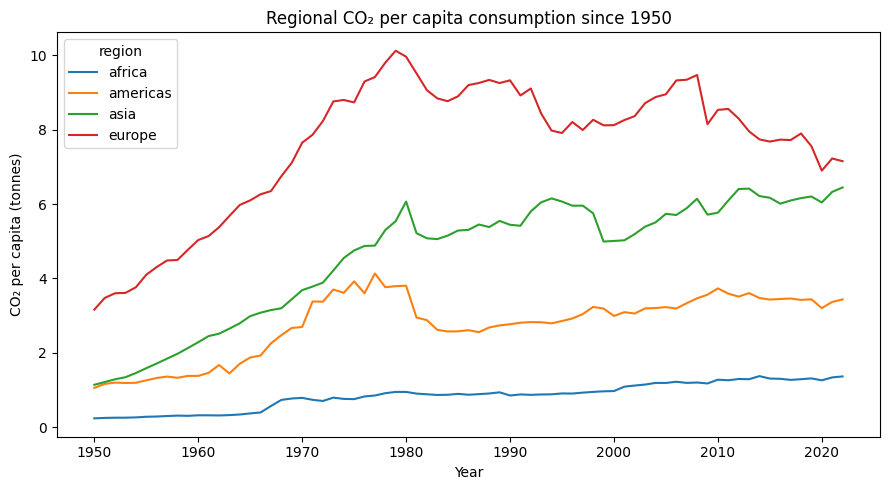

In [100]:
# plot regional CO2 per capita trends since 1950
co2_values = co2_panel.drop(columns='region').apply(pd.to_numeric, errors='coerce')
co2_tidy = (
    co2_values.stack().rename('co2').to_frame()
    .reset_index()
    .rename(columns={'level_0': 'country', 'level_1': 'year'})
)
co2_tidy['year'] = co2_tidy['year'].astype(int)
co2_tidy['region'] = co2_tidy['country'].map(co2_panel['region'])
co2_tidy = co2_tidy.dropna(subset=['co2', 'region'])

regional_co2 = (
    co2_tidy.groupby(['region', 'year'])['co2'].mean().reset_index()
)
plt.figure(figsize=(9, 5))
sns.lineplot(data=regional_co2, x='year', y='co2', hue='region')
plt.gca().xaxis.set_major_locator(MultipleLocator(10))
plt.xlabel('Year')
plt.ylabel('CO₂ per capita (tonnes)')
plt.title('Regional CO₂ per capita consumption since 1950')
plt.tight_layout()


In [101]:
# load life expectancy data for health outcome analysis
lex = pd.read_csv('data/lex.csv', index_col='country')
lex_cols_numeric = pd.to_numeric(lex.columns, errors='coerce')
lex_future_cols = lex.columns[(lex_cols_numeric.notna()) & (lex_cols_numeric > 2022)]
lex.drop(columns=lex_future_cols, inplace=True)
lex = lex.join(regions.rename(columns={'four_regions': 'region'}))
lex_panel = lex[years].copy()
lex_panel['region'] = lex['region']
lex_panel.head()


,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,region
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,42.7,42.9,43.1,43.5,43.3,43.9,44.1,44.3,44.5,44.7,...,61.9,61.9,62.0,62.9,62.7,63.3,62.3,61.8,62.6,asia
Angola,45.6,45.6,45.6,45.6,45.6,45.5,45.7,45.8,45.9,46.1,...,63.0,63.5,63.9,64.2,64.6,65.1,64.9,64.2,64.5,africa
Albania,52.2,53.6,54.5,55.4,56.1,56.3,58.0,59.3,61.0,61.7,...,78.2,78.1,78.2,78.3,78.4,78.5,76.2,75.7,76.1,europe
Andorra,74.6,74.7,74.8,75.0,75.1,75.2,75.3,75.4,75.5,75.6,...,82.0,82.0,82.1,82.1,82.1,82.2,78.3,79.6,82.7,europe
UAE,58.4,58.5,58.6,58.7,58.8,58.9,58.8,59.3,59.6,59.7,...,73.0,73.2,73.4,73.5,73.7,73.9,73.2,73.0,73.4,NaN


In [102]:
# tidy life expectancy data
lex_values = lex_panel.drop(columns='region').apply(pd.to_numeric, errors='coerce')
lex_tidy = (
    lex_values.stack().rename('lex').to_frame()
    .reset_index()
    .rename(columns={'level_0': 'country', 'level_1': 'year'})
)
lex_tidy['year'] = lex_tidy['year'].astype(int)
lex_tidy['region'] = lex_tidy['country'].map(lex_panel['region'])
lex_tidy = lex_tidy.dropna(subset=['lex', 'region'])
lex_tidy.head()


,country,year,lex,region
0,Afghanistan,1950,42.7,asia
1,Afghanistan,1951,42.9,asia
2,Afghanistan,1952,43.1,asia
3,Afghanistan,1953,43.5,asia
4,Afghanistan,1954,43.3,asia


In [103]:
# merge CO₂ and life expectancy for direct comparison
co2_tidy = (
    co2_panel.drop(columns='region').apply(pd.to_numeric, errors='coerce')
    .stack().rename('co2').to_frame()
    .reset_index()
    .rename(columns={'level_0': 'country', 'level_1': 'year'})
)
co2_tidy['year'] = co2_tidy['year'].astype(int)
co2_tidy['region'] = co2_tidy['country'].map(co2_panel['region'])
co2_tidy = co2_tidy.dropna(subset=['co2', 'region'])

lex_values = lex_panel.drop(columns='region').apply(pd.to_numeric, errors='coerce')
lex_tidy = (
    lex_values.stack().rename('lex').to_frame()
    .reset_index()
    .rename(columns={'level_0': 'country', 'level_1': 'year'})
)
lex_tidy['year'] = lex_tidy['year'].astype(int)
lex_tidy['region'] = lex_tidy['country'].map(lex_panel['region'])
lex_tidy = lex_tidy.dropna(subset=['lex', 'region'])

co2_lex = co2_tidy.merge(lex_tidy[['country', 'year', 'lex']], on=['country', 'year'], how='inner')
co2_lex = co2_lex.dropna(subset=['co2', 'lex'])
co2_lex.head()


,country,year,co2,region,lex
0,Afghanistan,1950,0.011,asia,42.7
1,Afghanistan,1951,0.012,asia,42.9
2,Afghanistan,1952,0.012,asia,43.1
3,Afghanistan,1953,0.013,asia,43.5
4,Afghanistan,1954,0.013,asia,43.3


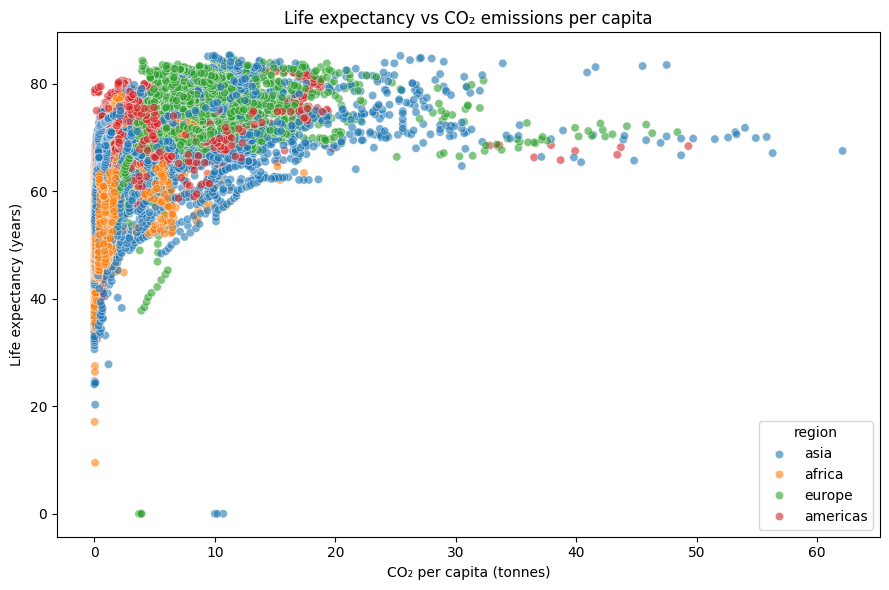

In [104]:
# scatter plot of life expectancy vs CO₂ emissions per capita
plt.figure(figsize=(9, 6))
sns.scatterplot(data=co2_lex, x='co2', y='lex', hue='region', alpha=0.6)
plt.xlabel('CO₂ per capita (tonnes)')
plt.ylabel('Life expectancy (years)')
plt.title('Life expectancy vs CO₂ emissions per capita')
plt.tight_layout()


In [105]:
# prepare tidy GDP data
gdp_values = gdp_panel.drop(columns='region').apply(pd.to_numeric, errors='coerce')
gdp_tidy = (
    gdp_values.stack().rename('gdp').to_frame()
    .reset_index()
    .rename(columns={'level_0': 'country', 'level_1': 'year'})
)
gdp_tidy['year'] = gdp_tidy['year'].astype(int)
gdp_tidy['region'] = gdp_tidy['country'].map(gdp_panel['region'])
gdp_tidy = gdp_tidy.dropna(subset=['gdp', 'region'])

co2_gdp = co2_tidy.merge(gdp_tidy[['country', 'year', 'gdp']], on=['country', 'year'], how='inner')
co2_gdp = co2_gdp.dropna(subset=['co2', 'gdp'])
co2_gdp.head()


,country,year,co2,region,gdp
0,Afghanistan,1950,0.011,asia,1450.0
1,Afghanistan,1951,0.012,asia,1500.0
2,Afghanistan,1952,0.012,asia,1540.0
3,Afghanistan,1953,0.013,asia,1620.0
4,Afghanistan,1954,0.013,asia,1650.0


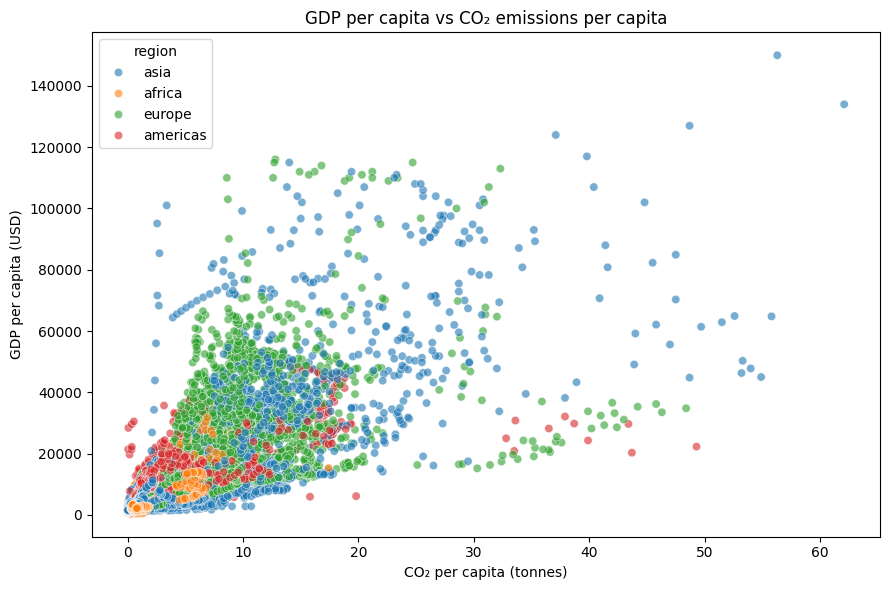

In [106]:
# scatter plot of GDP vs CO₂ emissions per capita
plt.figure(figsize=(9, 6))
sns.scatterplot(data=co2_gdp, x='co2', y='gdp', hue='region', alpha=0.6)
plt.xlabel('CO₂ per capita (tonnes)')
plt.ylabel('GDP per capita (USD)')
plt.title('GDP per capita vs CO₂ emissions per capita')
plt.tight_layout()


In [107]:
# prepare tidy GDP-life expectancy merge
gdp_values = gdp_panel.drop(columns='region').apply(pd.to_numeric, errors='coerce')
gdp_tidy = (
    gdp_values.stack().rename('gdp').to_frame()
    .reset_index()
    .rename(columns={'level_0': 'country', 'level_1': 'year'})
)
gdp_tidy['year'] = gdp_tidy['year'].astype(int)
gdp_tidy['region'] = gdp_tidy['country'].map(gdp_panel['region'])
gdp_tidy = gdp_tidy.dropna(subset=['gdp', 'region'])

lex_gdp = gdp_tidy.merge(lex_tidy[['country', 'year', 'lex']], on=['country', 'year'], how='inner')
lex_gdp = lex_gdp.dropna(subset=['gdp', 'lex'])
lex_gdp.head()


,country,year,gdp,region,lex
0,Afghanistan,1950,1450.0,asia,42.7
1,Afghanistan,1951,1500.0,asia,42.9
2,Afghanistan,1952,1540.0,asia,43.1
3,Afghanistan,1953,1620.0,asia,43.5
4,Afghanistan,1954,1650.0,asia,43.3


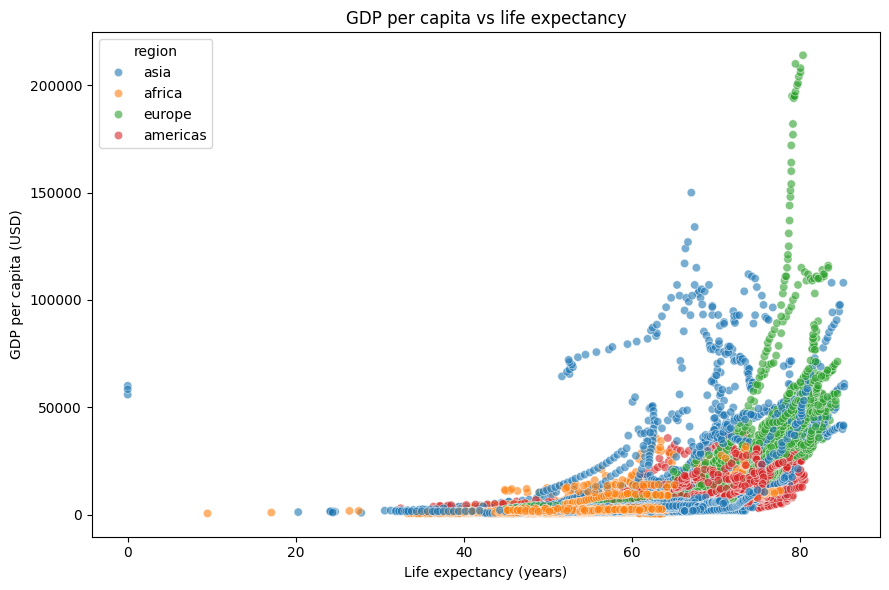

In [108]:
# scatter plot of GDP vs life expectancy
plt.figure(figsize=(9, 6))
sns.scatterplot(data=lex_gdp, x='lex', y='gdp', hue='region', alpha=0.6)
plt.xlabel('Life expectancy (years)')
plt.ylabel('GDP per capita (USD)')
plt.title('GDP per capita vs life expectancy')
plt.tight_layout()


In [109]:
# integrate CO₂, GDP, and life expectancy for a holistic view
co2_tidy = (
    co2_panel.drop(columns='region').apply(pd.to_numeric, errors='coerce')
    .stack().rename('co2').to_frame()
    .reset_index()
    .rename(columns={'level_0': 'country', 'level_1': 'year'})
)
co2_tidy['year'] = co2_tidy['year'].astype(int)
co2_tidy['region'] = co2_tidy['country'].map(co2_panel['region'])
co2_tidy = co2_tidy.dropna(subset=['co2', 'region'])

gdp_values = gdp_panel.drop(columns='region').apply(pd.to_numeric, errors='coerce')
gdp_tidy = (
    gdp_values.stack().rename('gdp').to_frame()
    .reset_index()
    .rename(columns={'level_0': 'country', 'level_1': 'year'})
)
gdp_tidy['year'] = gdp_tidy['year'].astype(int)
gdp_tidy['region'] = gdp_tidy['country'].map(gdp_panel['region'])
gdp_tidy = gdp_tidy.dropna(subset=['gdp', 'region'])

lex_values = lex_panel.drop(columns='region').apply(pd.to_numeric, errors='coerce')
lex_tidy = (
    lex_values.stack().rename('lex').to_frame()
    .reset_index()
    .rename(columns={'level_0': 'country', 'level_1': 'year'})
)
lex_tidy['year'] = lex_tidy['year'].astype(int)
lex_tidy['region'] = lex_tidy['country'].map(lex_panel['region'])
lex_tidy = lex_tidy.dropna(subset=['lex', 'region'])

co2_gdp_lex = (
    co2_tidy
    .merge(gdp_tidy[['country', 'year', 'gdp']], on=['country', 'year'], how='inner')
    .merge(lex_tidy[['country', 'year', 'lex']], on=['country', 'year'], how='inner')
)
co2_gdp_lex = co2_gdp_lex.dropna(subset=['co2', 'gdp', 'lex'])

latest_snapshot = (
    co2_gdp_lex.sort_values('year')
    .groupby('country', as_index=False)
    .tail(1)
)
latest_snapshot.head()


,country,year,co2,region,gdp,lex
1970,Botswana,2022,5.100,africa,15500.0,62.7
12548,Turkey,2022,4.950,europe,32900.0,79.0
10504,Russia,2022,9.970,europe,27700.0,69.2
12840,Uganda,2022,0.183,africa,2280.0,66.9
10577,Rwanda,2022,0.179,africa,2360.0,69.4


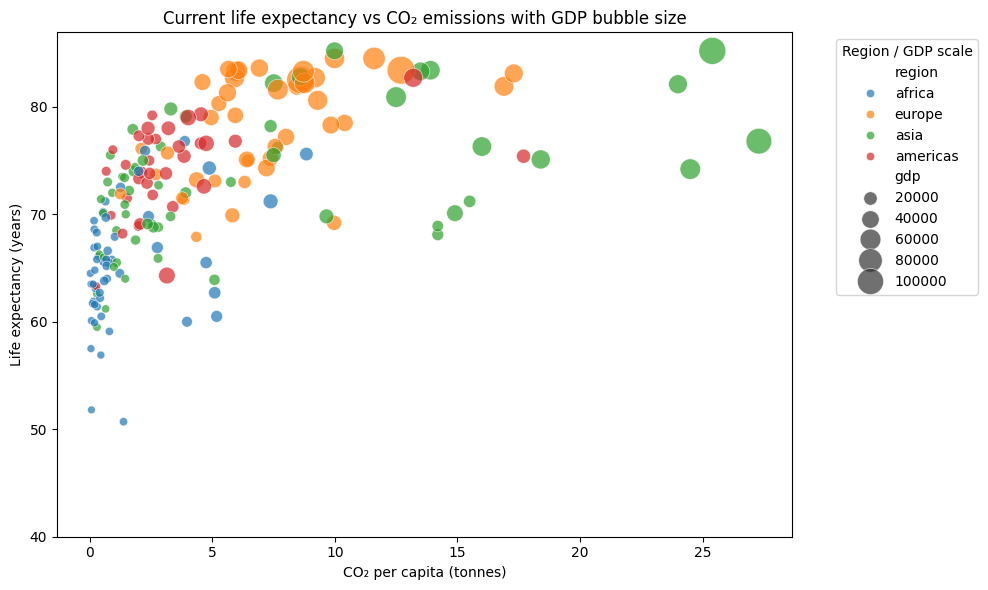

In [110]:
# bubble chart summarizing CO₂, GDP, and life expectancy
filtered_snapshot = latest_snapshot[latest_snapshot['lex'] >= 40].copy()
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_snapshot,
    x='co2',
    y='lex',
    hue='region',
    size='gdp',
    sizes=(30, 400),
    alpha=0.7,
    linewidth=0.5,
    edgecolor='white'
)
plt.xlabel('CO₂ per capita (tonnes)')
plt.ylabel('Life expectancy (years)')
plt.ylim(40, None)
plt.title('Current life expectancy vs CO₂ emissions with GDP bubble size')
plt.legend(title='Region / GDP scale', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
